In [1]:
# Run the example from documentation https://pyphi.readthedocs.io/en/nonbinary/examples/multivalued_elements.html

import pyphi
import numpy as np
pyphi.config.PARTITION_TYPE = 'ALL'
pyphi.config.MEASURE = 'AID'
pyphi.config.USE_SMALL_PHI_DIFFERENCE_FOR_CES_DISTANCE = True
pyphi.config.ASSUME_CUTS_CANNOT_CREATE_NEW_CONCEPTS = True

tpm = np.array([
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
])
num_states_per_node = [3, 2, 2]
names = ['P', 'C', 'N']
cm = [
     [0, 1, 1],
     [0, 0, 1],
     [1, 0, 0],
]
network = pyphi.Network(
tpm,
cm=cm,
node_labels=names,
num_states_per_node=num_states_per_node,
)

df = network.tpmdf

state = (0, 0, 1)
subsystem = pyphi.Subsystem(network, state)
sia = pyphi.compute.sia(subsystem)
sia.phi

Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]
Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



0.43872200000000006

In [2]:
# Get the TPMs for 143-168. First import the data
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import random

times = np.squeeze(np.load("Cori_2016-12-14/spikes.times.npy"))
clusters = np.squeeze(np.load("Cori_2016-12-14/spikes.clusters.npy"))
probe = np.squeeze(np.load("Cori_2016-12-14/clusters.probes.npy"))

minindex = min(clusters)
maxindex = max(clusters)

# split data into individual neuron arrays
individual_times = []
for i in range(minindex, maxindex+1):
    indices = np.where(clusters==i)[0]
    individual_times.append(times[indices].astype(float))

# get only the good neurons
annotations = np.squeeze(np.load("Cori_2016-12-14/clusters._phy_annotation.npy"))
good_indices = np.where(annotations >= 2)
good_neurons = np.array(individual_times)[good_indices].tolist()

probe1_indices = np.nonzero(probe)[0]
good_indices_probe1 = np.intersect1d(good_indices,probe1_indices)
print(good_indices_probe1.shape)
good_neurons_probe1 = np.array(individual_times)[good_indices_probe1]

n_143 = good_neurons_probe1[143]
n_168 = good_neurons_probe1[168]

(371,)
/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [3]:
import math
def binarise_spiketrain(a,S):
    """
    Binarises a spike-train with bins of size S. 
    - a is a list of times when the neuron fired. 
    """
    last = math.ceil(max(a)/S)
    a_states = np.zeros(math.ceil(max(a)/S))
    for spike_t in a:
        index = int(spike_t / S)
        a_states[index] = 1
    return a_states

def get_TPM_index(state):  # rename this
    """
    Given the state of a set of neurons, get the
    index into the TPM that the state corresponds to.

    Example: 
        state = [[1,0,0]
                 [0,1,1]]
        Neuron A is in state 100 and B is in state 011
        State A corresponds to the decimal 4
        State B corresponds to the decimal 3
        The index of A, the first listed state, varies 'fastest' in the TPM according to the PyPhi convention, 
        https://pyphi.readthedocs.io/en/latest/conventions.html.
        So, the indices, as tuples, will be (A0,B0),(A1,B0),(A2,B0),(A3,B0),(A4,B0),...,(A0,B1),(A1,B1)... 
        To convert these tuples to ints, we need A + B*8 = 4 + 3*8 = 28

        In general, where each node has n possible states, this becomes:
            - A*n^0 + B*n^1 + C*n^2 + ... where A, B, C are the states of each node,
            in order from first to last in the state input. 
            - Note that for the binary arrays accepted by this function, 
            n = 2^(m), where m is the size of the binary array that describes the state of a node. 
    """
    n = 2**(state.shape[1])
    index = 0
    for i in range(state.shape[0]):
        dec_node = int("".join(str(int(j)) for j in state[i,:]), 2)
        index += dec_node * n ** i
    return index

def get_TPM_nonbinary(binaryneurons, K, skipby, required_obs):
    """Given an array of binarised neuron spike-trains
    and a K value for how many time-steps to include in a single state, 
    get the TPM of the system. 
        - Skipby controls where the future state starts: given that the current state
        starts at T, future state starts at T+skipby
    Example: 
        if K = 3, then find the TPM that describes 
        the transition probability of System[t-2,t-1,t] --> System[t+1,t+2,t+3]

    Returns:
        - A TPM of the system in state-state mode (TODO: conventions?)
        - A matrix A with the same dimensions of TPM, where A[i,j] is the 
        number of transitions that were used to calculate the value of TPM[i,j].
    
    """
    assert K >= 1
    assert binaryneurons.shape[0] >= 1

    size = (2**K)**binaryneurons.shape[0]
    
    # initialise TPM and num_transitions arrays
    TPM = np.zeros((size, size))
    num_transitions = np.zeros((size, size))

    # get a randomly ordered list of indices at which to look at transitions
    # start at K-1 because our state at time i looks BACK to i-1, i-2,.. to build the rest of state
    rand_indices = np.array(list(range(K-1, binaryneurons.shape[1] - skipby)))
    np.random.shuffle(rand_indices)

    for i in rand_indices:
        curr_state = binaryneurons[:,i-(K-1):(i+1)]
        i_c = get_TPM_index(curr_state)
        total = sum(num_transitions[i_c,:])
        if total >= required_obs:   # don't add this observation if we already have enough
            continue

        future_state = binaryneurons[:,i-(K-1) + skipby:(i+1) + skipby]   # Ugly indexing 
        i_f = get_TPM_index(future_state)

        num_transitions[i_c, i_f] += 1
    
    for j in range(num_transitions.shape[0]):
        total = sum(num_transitions[j,:])
        if total < required_obs:
            raise ValueError("State with index " + str(j) + \
            " was observed in the data fewer than " + str(required_obs) + " times, (" + str(total) + " times only).")
        
        TPM[j,:] = num_transitions[j,:] / total
    
    return TPM, num_transitions

def TPM_from_spiketrains(spiketrains, S, K, skip, required_obs):

    # get the binarised spike trains for each neuron
    # create a multidimensional array of the spiketrains by not considering further than the shortest train
    binarised_trains = [[] for _ in range(len(spiketrains))]
    min_length = math.inf
    for i in range(len(spiketrains)):
        binarised_trains[i] = binarise_spiketrain(spiketrains[i], S)
        min_length = min(min_length, len(binarised_trains[i]))
    
    binarised_trains = np.array([binarised_trains[i][0:min_length] for i in range(len(binarised_trains))])   # probably slow? 
    # compute the TPM 
    return get_TPM_nonbinary(binarised_trains, K, skip, required_obs)
     


In [5]:

def coarse_grain_nonbinary_TPM(TPM, state_map, num_states_per_elem):
    """
    TODO: add checks to inputs

    Turns a nonbinary TPM into a binary TPM by coarse-graining each nonbinary element
    according to a grouping.
        - grouping only groups states of individual elements.
        - grouping example for a TPM of 2 elements each w 4 states:
        [[[0, 1], [2, 3]], [[0], [1, 2], [3]]]
            - The first element's 0 and 1 states are grouped into a state, and 2,3 into another.
            - The second element's 0 state stays the same, 1,2 are grouped and 3 stays the same.

    state_map:
        - a dictionary that takes in the index of a macro state, obtained from num_states_per_elem
        and returns a list of micro states to the TPM that make up the macro state. 

    For example, for a TPM of 2 elements, each with 4 states,
    the input TPM will have 4*4 = 16 states. We can coarse grain
    such that only the first three states of each element will be grouped into an OFF state,
    and the last element will be grouped into ON. 

    However, we don't have to coarsegrain to binary. We might say that the first state
    of each element will map to OFF, the second and third will map to FIRING, 
    fourth to BURSTING. 

    AB
    00 ....
    10
    20
    01
    11
    21
    02
    12
    22
    """
    num_states = 1
    for i in num_states_per_elem:
        num_states *= i

    new_TPM = np.zeros((num_states, num_states))
    for i in range(num_states):
        input_micro_indices = state_map[i]
        for j in range(num_states):
            output_micro_indices = state_map[j]
            
            total_prob = 0
            for output_state in output_micro_indices:
                avg_for_output_state = 0
                for input_state in input_micro_indices:
                    avg_for_output_state += TPM[input_state, output_state]

                avg_for_output_state = avg_for_output_state / len(input_micro_indices)
                total_prob += avg_for_output_state
    
            new_TPM[i,j] = total_prob
    return new_TPM


def get_state_map(coarse_grain):
    # get how many macro states we have
    num_micro_states_per_elem = []
    num_macro_states = 1
    for elem in coarse_grain:
        num_macro_states *= len(elem)
        num_micro_states_per_elem.append(sum(len(x) for x in elem))

    state_map = {i : [] for i in range(num_macro_states)}
    
    # for each micro state, get its index, and then get its macro index
    # to get macro state from a micro index, we need 


In [37]:
# 2 elements, each three states
TPM = np.array([
    [0.7, 0, 0, 0.1, 0.1, 0.1, 0, 0, 0],        # 0,0 - 0
    [0.5, 0.1, 0.05, 0.05, 0.1, 0, 0, 0.1, 0.1],# 1,0 - 1
    [0.5, 0.1, 0.05, 0.05, 0.1, 0, 0, 0.1, 0.1],# 2,0 - 2
    [0.5, 0.1, 0.05, 0.05, 0.1, 0, 0, 0.1, 0.1],# 0,1 - 3 
    [0, 0, 0.7, 0, 0, 0.1, 0.1, 0.1, 0],        # 1,1 - 4
    [0.7, 0, 0, 0.1, 0.1, 0.1, 0, 0, 0],        # 2,1 - 5
    [0.4, 0.1, 0.05, 0.05, 0.1, 0, 0, 0.1, 0.2],# 0,2 - 6
    [0, 0, 0.7, 0, 0, 0.1, 0.1, 0.1, 0],        # 1,2 - 7
    [0.7, 0, 0, 0.1, 0.1, 0.1, 0, 0, 0]         # 2,2 - 8
    ])
num_states_per_elem = [2,2]

# groupings: [[0,1], [2]], [[0,1], [2]] 
# --> for each state in the previous elem, multiply by each in the current state
# --> [[0,1], [2]] mult_each [[0,1], [2]] --> [0,1]*[0,1] = [0 + 0] 
state_map = {0: [0,1,3,4], 1: [2, 5], 2: [6,7], 3:[8]}
new_TPM = coarse_grain_nonbinary_TPM(TPM, state_map, num_states_per_elem)
new_TPM

array([[0.6  , 0.25 , 0.1  , 0.05 ],
       [0.825, 0.075, 0.05 , 0.05 ],
       [0.325, 0.425, 0.15 , 0.1  ],
       [0.9  , 0.1  , 0.   , 0.   ]])

In [41]:
neurons = [143,168]
cluster_143_168 = good_neurons_probe1[neurons]
TPM = TPM_from_spiketrains(cluster_143_168,0.005,2,2,2000)


In [40]:
97 + 56 + 63 + 81 + 44 + 40 + 42 + 82 + 44 + 36 + 48 + 125 + 19 + 46 + 40 + 137

1000

In [42]:
# groupings: [[0,1,2], [3]], [[0,1,2], [3]]
"""
00 0
10 1 
20 2 
30 3

01 4 
11 5
21 6 
31 7 

02 8
12 9
22 10
32 11

03 12 
13 13 
23 14 
33 15
"""
num_states_per_elem = [2,2]
state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
macro_TPM = coarse_grain_nonbinary_TPM(TPM[0], state_map, num_states_per_elem)
macro_TPM

array([[0.88083333, 0.06005556, 0.04405556, 0.01505556],
       [0.7005    , 0.15633333, 0.07783333, 0.06533333],
       [0.75783333, 0.10866667, 0.09566667, 0.03783333],
       [0.4835    , 0.2505    , 0.113     , 0.153     ]])

In [144]:
# Micro analysis for the system of neurons containing 143, 168. 
import pyphi
import numpy as np
pyphi.config.PARTITION_TYPE = 'ALL'
pyphi.config.MEASURE = 'AID'
#pyphi.config.USE_SMALL_PHI_DIFFERENCE_FOR_CES_DISTANCE = True
#pyphi.config.ASSUME_CUTS_CANNOT_CREATE_NEW_CONCEPTS = True



def get_micro_average_phi(TPM):
    network = pyphi.Network(
    (TPM),
    num_states_per_node=[4,4]
    )
    phis = []
    states = get_nary_states(2,4)
    for state in states:
        subsystem = pyphi.Subsystem(network, state)
        sia = pyphi.compute.sia(subsystem)
        if state == (0,1):
            print(sia.ces)
            print(sia.partitioned_ces)
            print(sia.cut)
        phis.append(sia.phi)
    print(phis)
    return sum(phis) / len(phis)
get_micro_average_phi(TPM)

Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]════════════════════════════════════════════════════════════
            Cause-effect structure (3 concepts)             
════════════════════════════════════════════════════════════
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
           Concept: Mechanism = [A], φ = 0.17977            
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
              MIC                         MIE               
  ┌──────────────────────────┐┌──────────────────────────┐  
  │  φ = 0.17977             ││  φ = 0.448622            │  
  │  Purview = [A]           ││  Purview = [A, B]        │  
  │  MIP:                    ││  MIP:                    │  
  │     A     ∅              ││     A     ∅              │  
  │    ─── ✕ ───             ││    ─── ✕ ───             │  
  │     ∅     A              ││     ∅    A,B             │  
  │  Repertoire:             ││  Repertoire:             │  
  │    ┌────────────────┐   

0.006445125

In [145]:
def get_macro_average_phi(micro_TPM):

    num_states_per_elem = [2,2]
    state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
    macro_TPM = coarse_grain_nonbinary_TPM(micro_TPM, state_map, num_states_per_elem)
    #np.savetxt("TPMs/macro_example_143_168.csv", macro_TPM)
    # Macro analysis where bursting is one state, and everything else is another
    network = pyphi.Network(
    macro_TPM,
    num_states_per_node=[2,2]
    )

    states = reversed(get_nary_states(2,2))
    phis = []
    for state in states:
        subsystem = pyphi.Subsystem(network, state)
        sia = pyphi.compute.sia(subsystem)
        phis.append(sia.phi)
    print(sia.ces)
    print(sia.partitioned_ces)
    print(sia.cut)
    return sum(phis) / len(phis)


In [146]:
get_macro_average_phi(TPM)

                                                                ════════════════════════════════════════════════════════════
            Cause-effect structure (3 concepts)             
════════════════════════════════════════════════════════════
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
           Concept: Mechanism = [A], φ = 0.10726            
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
              MIC                         MIE               
  ┌──────────────────────────┐┌──────────────────────────┐  
  │  φ = 0.10726             ││  φ = 0.220499            │  
  │  Purview = [A]           ││  Purview = [A, B]        │  
  │  MIP:                    ││  MIP:                    │  
  │     A     ∅              ││     A     ∅              │  
  │    ─── ✕ ───             ││    ─── ✕ ───             │  
  │     ∅     A              ││     ∅    A,B             │  
  │  Repertoire:             ││  Repertoire:             │  
  │    ┌─────────────

0.00011200000000000099

In [89]:
micro_phis = []
macro_phis = []
for _ in range(50):
    num_transitions = 2000
    TPM,_ = TPM_from_spiketrains(cluster_143_168,0.005,2,2,num_transitions)
    #np.savetxt("TPMs/micro_example_143_168.csv", TPM)
    micro_phis.append(get_micro_average_phi(TPM))
    macro_phis.append(get_macro_average_phi(TPM))
print(micro_phis, macro_phis)

Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s][0.0, 0.022172000000000025, 0.0037109999999999643, 0.0, 0.0, 0.0, 0.004830000000000001, 0.01331199999999999, 0.02241000000000004, 0.0, 0.0, 0.0034029999999999894, 0.014363999999999932, 0.0, 0.0, 0.01275700000000013]
[0.0, 0.0, 0.0015650000000000108, 0.0]
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s][0.0, 0.0013300000000000534, 0.0, 0.0, 0.0035710000000000186, 0.0, 0.0, 0.012106000000000006, 0.019292999999999977, 0.0029890000000000055, 0.0029889999999999917, 0.0029890000000000194, 0.02635399999999999, 0.0, 0.0, 0.010113999999999956]
[0.0, 0.001580999999999999, 0.004279000000000005, 0.0]
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s][0.0, 0.007491999999999999, 0.00437499999999999, 0.0, 0.0, 0.0, 0.0, 0.005679000000000017, 0.03579399999999999, 0.0, 0.0, 0.0, 0.02865300000000004, 0.0, 0.0, 0.006092000000000097]
[0.0, 0.00013999999999997348, 0.0021750000000000103, 0.0]
Computing concepts:   0%|          | 0/3 [0

0.006445125 0.00011200000000000099


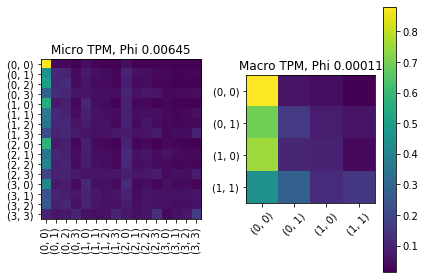

In [128]:
print(micro_phis[-1], macro_phis[-1])
np.savetxt("TPMs/micro_example_143_168.csv", np.around(TPM, 4), fmt='%.5e')
np.savetxt("TPMs/macro_example_143_168.csv", np.around(macro_TPM, 4), fmt='%.5e')

plt.subplot(1, 2, 1)
states = get_nary_states(2,4)
states = [str(state) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(TPM,extent=None)
plt.title("Micro TPM, Phi 0.00645")

plt.subplot(1, 2, 2)
states = get_nary_states(2,2)
states = [str(state) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=45)
plt.imshow(macro_TPM,extent=None)
plt.title("Macro TPM, Phi 0.00011")

plt.colorbar()
plt.tight_layout() 


([<matplotlib.axis.XTick at 0x132d39780>,
 <a list of 2 Text xticklabel objects>)

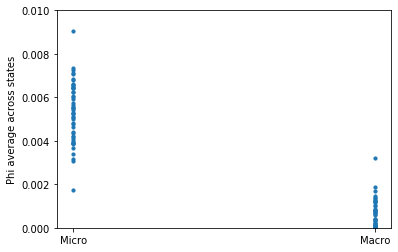

In [90]:
import matplotlib.pyplot as plt
plt.scatter([1 for _ in range(50)] + [2 for _ in range(50)],[micro_phis,macro_phis],s=10)
plt.ylim([0,0.01])
plt.ylabel("Phi average across states")
plt.xticks([1,2],["Micro", "Macro"])


In [35]:
def spatial_emergence_for_timeseries(neuron_data,S,skip,state):
    K=1 #For now all TPMs will be binary.
    TPM = TPM_from_spiketrains(neuron_data,0.005,1,1)
    network = pyphi.Network(pyphi.convert.state_by_state2state_by_node(TPM[0])) # look into the need for having state by node.

    # micro Phi
    subsystem = pyphi.Subsystem(network, state)
    sia = pyphi.compute.sia(subsystem)
    micro_phi = sia.phi


    # macro Phi
    max_coarse_grain = pyphi.macro.emergence(network, state)
    macro_phi = max_coarse_grain.phi

    return micro_phi, macro_phi


In [32]:
def get_bin_states(l):
    states = []
    for i in range(2**l):
        state = list(bin(i)[2:])
        while len(state) < l:
            state.insert(0,'0')
        state = tuple([int(c) for c in state])
        states.append(state)
    return states

def get_nary_states(n,b):
    states = []
    for i in range(b**n):
        state = numberToBase(i,b)
        while len(state) < n:
            state.insert(0,0)
        state = tuple(state)
        states.append(state)
    return states

# https://stackoverflow.com/a/28666223/6370263
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]

get_nary_states(2,4)

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [50]:


neuron_sets = [[143,168,293,331], [10,23], [38,207],[171,232,291], [55,305,348]]
phis = []
for n_set in [[143,168,293,331]]:
    data = good_neurons_probe1[n_set]
    for state in get_bin_states(len(n_set)):
        phis.append(spatial_emergence_for_timeseries(data, 0.005,1,state))


Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.92it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  5.38it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.61it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  5.59it/s]
                                                                 
Computing concepts: 100%|██████████| 15/15 [00:04<00:00,  1.20it/s]
                                                                   
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  8.87it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  6.44it/s]
      

In [37]:
phis = []
for n_set in [[55,305,348]]:
    data = good_neurons_probe1[n_set]
    for state in [(0,0,0), (1,0,0), (0,1,0), (1,1,0), (0,0,1), (1,0,1), (0,1,1), (1,1,1)]:
        phis.append(spatial_emergence_for_timeseries(data, 0.005,1,state))

average_micro = 0
average_macro = 0
for tup in phis: 
    print(tup)
    average_micro += tup[0]
    average_macro += tup[1]
average_micro = average_micro / len(phis)
average_macro = average_macro / len(phis)

print(average_micro)
print(average_macro)


(0.006674, 0.009084)
(0.018888, 0.006618)
(0.004878, 0.012929)
(0.012769, 0.009735)
(0.007304, 0.012929)
(0.014651, 0.009735)
(0.00483, 0.012929)
(0.009809, 0.009735)
0.009975375
0.010461749999999999


In [51]:
average_micro = 0
average_macro = 0
for tup in phis: 
    print(tup)
    average_micro += tup[0]
    average_macro += tup[1]
average_micro = average_micro / len(phis)
average_macro = average_macro / len(phis)

print(average_micro)
print(average_macro)


(0.051797, 0.029642)
(0.064329, 0.027689)
(0.171198, 0.028817)
(0.15693, 0.03316)
(0.058418, 0.047017)
(0.063779, 0.037474)
(0.090376, 0.041201)
(0.089124, 0.04068)
(0.050768, 0.047017)
(0.072757, 0.037474)
(0.090483, 0.041201)
(0.092822, 0.04068)
(0.051709, 0.047017)
(0.069364, 0.037474)
(0.072037, 0.041201)
(0.091009, 0.04068)
0.08355625
0.038651500000000005
